In [1]:
import os

In [2]:
os.chdir(os.path.split(os.getcwd())[0])

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import matplotlib.style as style

In [5]:
style.use('seaborn-poster')

### Parse raw logs and create DataFrame

In [54]:
def parse_raw_log(log):
    data = []
    lines = log.split('\n')
    for line in lines[:-1]:
        raw = line.split(': ')
        if raw[0].split(', ')[1] == 'LOG':
            entries = raw[1].split(', ')
            datum = []
            for entry in entries:
                value = entry.split(':')[1]
                try:
                    datum.append(float(value))
                except ValueError:
                    datum.append(value)

            data.append(datum)
    
    return data

In [69]:
experiment_folder = 'Oct19_Trial'
log_path = os.path.join('experiments', experiment_folder, 'training.log')
with open(log_path, 'r') as f:
    log = f.read()
    
data = parse_raw_log(log)

columns = ['episode', 'step', 'S', 'c', 'delta', 'n', 'action', 'dn', 'kind', 'epsilon', 'pnl', 'reward', 'best_mean_reward', 'loss']
data_df = pd.DataFrame(data, columns = columns)
data_df = data_df.astype({'episode': int, 'step': int, 'action': int})

In [70]:
data_df[data_df['episode'] == 2].head()

,episode,step,S,c,delta,n,action,dn,kind,epsilon,pnl,reward,best_mean_reward,loss
50,2,1,100.982479,6.645999,0.555840,26.0,126,26.0,random,0.999,69.447108,-100.000000,-4808.504704,20094.896484
51,2,2,100.964498,6.573261,0.555327,51.0,125,25.0,random,0.999,-11.315876,-20.843329,-4808.504704,17422.447266
52,2,3,100.930455,6.490967,0.554390,98.0,147,47.0,random,0.999,-18.474562,-42.449035,-4808.504704,24016.820312
53,2,4,98.284766,5.053841,0.483195,117.0,119,19.0,random,0.999,-455.519216,-100.000000,-4808.504704,19604.025391
54,2,5,97.727411,4.725669,0.466954,48.0,31,-69.0,random,0.999,-71.231306,-100.000000,-4808.504704,18422.378906


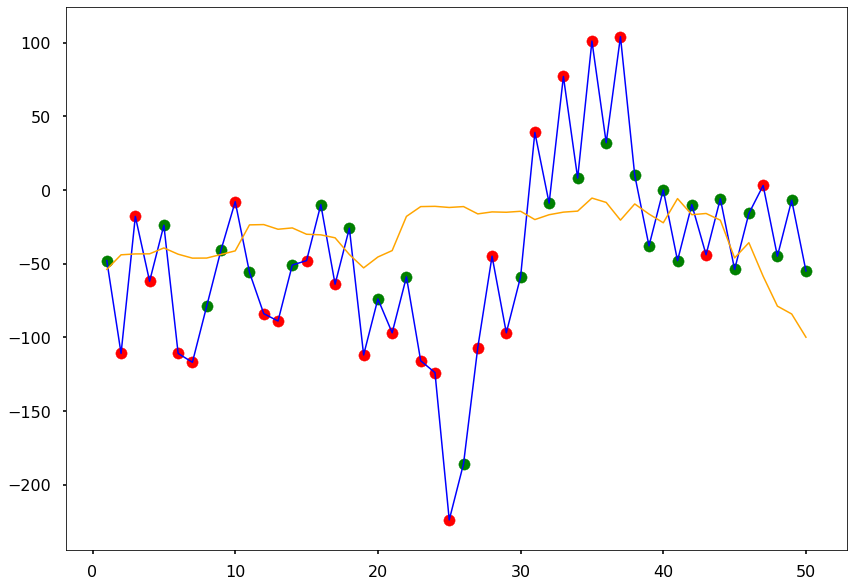

In [71]:
episode = 750
episode_df = data_df[data_df['episode'] == episode]

fig, ax = plt.subplots(figsize = (14, 10), nrows = 1, ncols = 1, sharex = True)
ax.plot(episode_df['step'], episode_df['n'], color = 'blue', lw = 1.5)
ax.plot(episode_df['step'], episode_df['delta'] * -100, color = 'orange', lw = 1.5)
ax.scatter(episode_df[episode_df['kind'] == 'random']['step'], episode_df[episode_df['kind'] == 'random']['n'], color = 'red')#, facecolor = 'None')
ax.scatter(episode_df[episode_df['kind'] == 'policy']['step'], episode_df[episode_df['kind'] == 'policy']['n'], color = 'green')

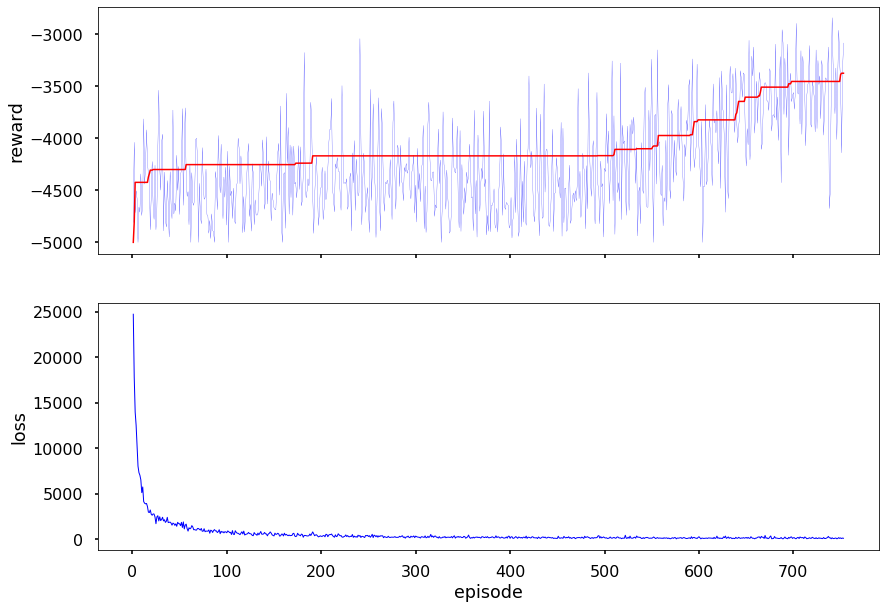

In [72]:
fig, ax = plt.subplots(figsize = (14, 10), nrows = 2, ncols = 1, sharex = True)
groupby_episode = data_df.groupby('episode').mean()
rewards = data_df.groupby('episode').sum()['reward'].values[:-1]
best_mean_reward = groupby_episode['best_mean_reward'].values[:-1]
mean_loss = groupby_episode['loss'].values[:-1]

ax[0].plot(np.arange(1, len(rewards) + 1), np.clip(rewards, -5000, None), label = 'reward', color = 'blue', lw = 0.2)
ax[0].plot(np.arange(1, len(best_mean_reward) + 1), np.clip(best_mean_reward, -5000, None), label = 'best_mean_reward', color = 'red', lw = 1.5)
ax[0].set_ylabel('reward')

ax[1].plot(np.arange(1, len(mean_loss) + 1), mean_loss, label = 'loss', color = 'blue', lw = 1)
ax[1].set_xlabel('episode')
ax[1].set_ylabel('loss')
plt.show()